2025-08-03 23:10:57,077 [INFO] [__main__] 🚀 Starting MPT Portfolio Optimizer
2025-08-03 23:10:57,078 [INFO] [__main__] Fetching S&P 500 tickers from Wikipedia...
2025-08-03 23:10:57,578 [INFO] [__main__] Retrieved 503 tickers.
2025-08-03 23:10:57,579 [INFO] [__main__] ⬇️ Downloading historical price data...
2025-08-03 23:11:07,889 [INFO] [__main__] Downloaded data for 490 tickers (removed 13 with missing data).
2025-08-03 23:11:07,890 [INFO] [__main__] Calculating log returns...
2025-08-03 23:11:07,937 [INFO] [__main__] Starting Monte Carlo simulation for portfolio optimization...
2025-08-03 23:11:12,357 [INFO] [__main__] Optimal portfolio found with Sharpe Ratio = 0.4438
2025-08-03 23:11:12,358 [INFO] [__main__] Displaying optimal portfolio allocation...
2025-08-03 23:11:12,361 [INFO] [__main__] Top allocations (>1%):
Series([], dtype: float64)
2025-08-03 23:11:12,363 [INFO] [__main__] Plotting the efficient frontier...


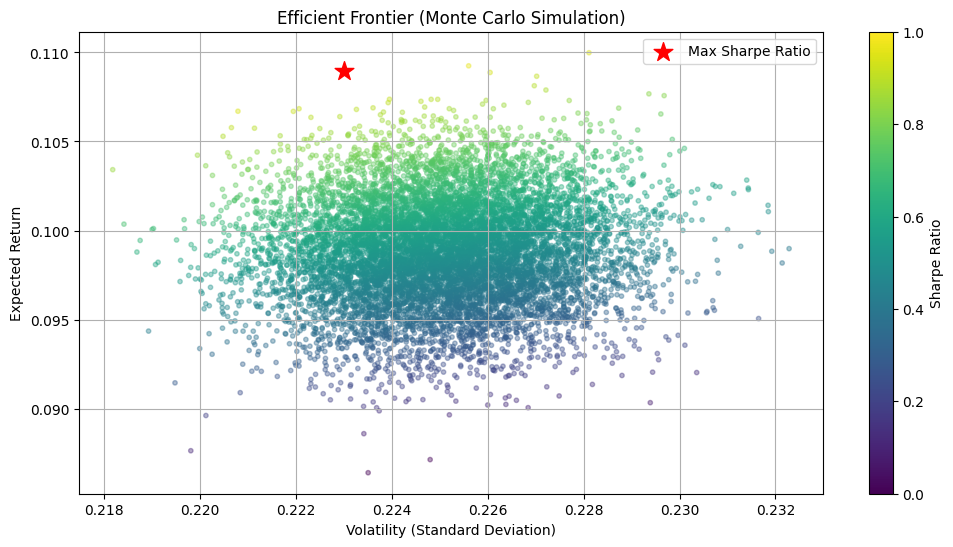

2025-08-03 23:11:12,627 [INFO] [__main__] ✅ Workflow complete.


In [2]:
# mpt_optimizer.py
import logging
from logger_config import *  # ⬅️ Ensure this is imported first to configure logging

# Other imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

def get_sp500_tickers():
    logger.info("Fetching S&P 500 tickers from Wikipedia...")
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)
    tickers = table[0]['Symbol'].tolist()
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    logger.info(f"Retrieved {len(tickers)} tickers.")
    return tickers

def download_price_data(tickers, start='2020-01-01', end='2025-01-01'):
    logger.info("⬇️ Downloading historical price data...")
    data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)['Close']
    valid_data = data.dropna(axis=1, how='any')
    logger.info(f"Downloaded data for {valid_data.shape[1]} tickers (removed {len(tickers) - valid_data.shape[1]} with missing data).")
    return valid_data

def calculate_log_returns(data):
    logger.info("Calculating log returns...")
    return np.log(data / data.shift(1)).dropna()

def optimize_portfolio(returns, num_portfolios=10000, risk_free_rate=0.01):
    logger.info("Starting Monte Carlo simulation for portfolio optimization...")
    np.random.seed(42)
    num_assets = returns.shape[1]
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252

    results = np.zeros((4, num_portfolios))
    weight_array = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weight_array.append(weights)

        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        if portfolio_stddev == 0:
            results[:, i] = [0, 0, -np.inf, i]
            continue

        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
        results[0, i] = portfolio_return
        results[1, i] = portfolio_stddev
        results[2, i] = sharpe_ratio
        results[3, i] = i

    max_sharpe_idx = np.argmax(results[2])
    optimal_weights = weight_array[int(results[3, max_sharpe_idx])]

    logger.info(f"Optimal portfolio found with Sharpe Ratio = {results[2, max_sharpe_idx]:.4f}")
    return results, weight_array, optimal_weights, mean_returns.index

def display_optimal_portfolio(optimal_weights, tickers):
    logger.info("Displaying optimal portfolio allocation...")
    portfolio = pd.Series(optimal_weights, index=tickers)
    portfolio.to_csv("optimal_portfolio_full.csv")
    filtered = portfolio[portfolio > 0.01].sort_values(ascending=False)
    logger.info(f"Top allocations (>{1}%):\n{filtered}")
    return portfolio

def main():
    logger.info("🚀 Starting MPT Portfolio Optimizer")
    tickers = get_sp500_tickers()
    data = download_price_data(tickers)

    if data.shape[1] < 2:
        logger.warning("❌ Not enough tickers with valid data to build a portfolio.")
        return

    returns = calculate_log_returns(data)
    results, weight_array, optimal_weights, selected_tickers = optimize_portfolio(returns)
    display_optimal_portfolio(optimal_weights, selected_tickers)

    # Efficient frontier plot
    logger.info("Plotting the efficient frontier...")
    plt.figure(figsize=(12, 6))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.4)
    max_idx = np.argmax(results[2])
    plt.scatter(results[1, max_idx], results[0, max_idx], color='red', marker='*', s=200, label='Max Sharpe Ratio')
    plt.title('Efficient Frontier (Monte Carlo Simulation)')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()
    logger.info("✅ Workflow complete.")

if __name__ == "__main__":
    main()
